# selected context sentences

In [1]:
from sentence_transformers import SentenceTransformer
from scipy.spatial.distance import cosine
from scipy import stats
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import json, random

In [ ]:
## load context sentences dataset into dictionary
model = SentenceTransformer('outputs/SentMatBERT_MNR')
with open('data/zt_ori_84.txt', 'r') as f:
    lines = f.readlines()
    names = [line.strip().split('\t')[0] for line in lines]
    zt_scores = [line.strip().split('\t')[-1] for line in lines]
with open('data/thermo_sens.json','r') as f1:
    string = f1.read()
    thermo_sents = json.loads(string)   # 200 thermoelectric context sentences
with open('data/mat_sens.json','r', encoding='utf-8') as f2:
    string = f2.read()
    dictionary = json.loads(string)   # a dictionary of dictionaries
dict_84 = {}
for d in dictionary.values():
    if 'if_84' in d.keys():
        if 'sens' in d.keys():
            dict_84[d['ori']] = d['sens']
        else:
            dict_84[d['ori']] = d['ori']

## sample context sentences over limit (100 or 200)
# mat_without_sents = [key for key,value in dict_84.items() if key == value]   # 8 materials without sentences
mat_over_limit = [key for key,value in dict_84.items() if len(value) > 200]   # 26/24/23 materials have more than 100/150/200 sentences
# print(len(mat_over_limit))
for key,value in dict_84.items():
    if type(value) == list and len(value) > 200:
        dict_84[key] = random.sample(value, 200)
dict_84['thermoelectric'] = thermo_sents

def select_context_sentences(num):
    '''select certain number of context sentences according to their similarities with material names 
       :num param: the number of context sentences to be selected for each material and the center word'''
    selected_sents = {}
    for key,value in dict_84.items():
        if type(value) == list and len(value) >= num:
            name_embedding = model.encode(key)
            sent_embeddings = model.encode(value)
            cos_sims = [1-cosine(sent_embedding,name_embedding) for sent_embedding in sent_embeddings]
            # select one most similar context sentence for each material: 0.26545034834536724
            # idx = cos_sims.index(max(cos_sims))   # list.index(item) returns the index of the item's first occurrence
            # selected_sent[key] = value[idx]
            selected_sents[key] = [sent for num,sent in sorted(list(zip(cos_sims,value)), reverse=True)][0:num]   # slicing
        else:
            selected_sents[key] = value     
    return selected_sents   # note the indentation of "return", usually 4 dents from "def"
# print(selected_sents['Cu2Se'])
# print(selected_sents['thermoelectric'])

def context_average(selected_sents):
    '''calculate spearman correlation for selected context sentences'''
    center_embedding = np.mean(model.encode(selected_sents['thermoelectric']), axis=0)
    cos_sims = []
    for name in names:
        if type(selected_sents[name]) == list:
            encoded = model.encode(selected_sents[name])
            embedding = np.mean(encoded, axis=0)
        else:
            embedding = model.encode(selected_sents[name])
        cos_sim = 1-cosine(center_embedding, embedding)
        cos_sims.append(cos_sim)
    corr, pvalue = stats.spearmanr(cos_sims, zt_scores)
    return corr

def method1(nums):
    '''try out different context sentence number settings, returns the best num and the best corr as a tuple
       :nums param: a list of numbers to iterate over'''
    correlations = []
    for num in tqdm(nums):
        sents = select_context_sentences(num)
        corr = context_average(sents)
        correlations.append(corr)
    print(list(zip(nums, correlations)))   # num_corr_tuples
    plt.scatter(nums, correlations)
    plt.xlabel('num of selected context sents')
    plt.ylabel('spearman correlation')
    plt.show()
    idx = correlations.index(np.max(correlations))
    return (nums[idx], correlations[idx])

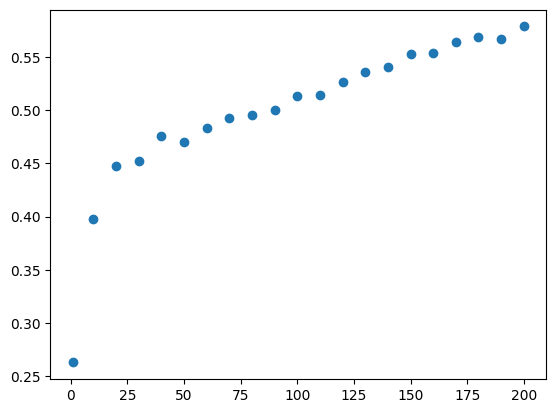

In [4]:
# nums = list(range(1,100,5))   # best num 96, best corr 0.5631 (num_corr_scatter_1.png)
nums = [1] + list(range(10,201,10))   # best num 200, best corr 0.5785 (num_corr_scatter_2.png)
# best_num, best_corr = method1(nums)

num_corr_tuples = [(1, 0.2629), (10, 0.3973), (20, 0.4471), (30, 0.4525), (40, 0.4753), (50, 0.4697), (60, 0.4827), (70, 0.4923), (80, 0.4952), 
                   (90, 0.5003), (100, 0.5135), (110, 0.5144), (120, 0.5263), (130, 0.5356), (140, 0.5407), (150, 0.5528), (160, 0.5536), 
                   (170, 0.5635), (180, 0.5688), (190, 0.5663), (200, 0.5785)]
corrs = [corr for num,corr in num_corr_tuples]
plt.scatter(nums, corrs)

In [ ]:
## sampling context sentences causes the undulation of results (above 0.57, maximum 0.5924)
## main conclusion of this script: more context sentences leads to better result